# Import libraries

In [27]:
import os
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color, simulate_genos, calculate_true_maf_per_pop
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

In [28]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [29]:
risk = "hi_gauss_blob_risk_fun"

# Create genotype

In [30]:
dict = parse_variables('geno_simulation.txt')
G = 100
L = 10
c = 1000
k = 3
M = 20
HWE = 1

very_rare_to_save, rare_to_save, common_to_save, geno = simulate_genos(G, L, c, k, M, HWE)
proto_geno = geno.copy()

humans = pd.DataFrame()
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

humans["populations"] = labels_pop

true_p2s, true_twopqs, true_q2s = calculate_true_maf_per_pop(geno, humans)

# visualise populations

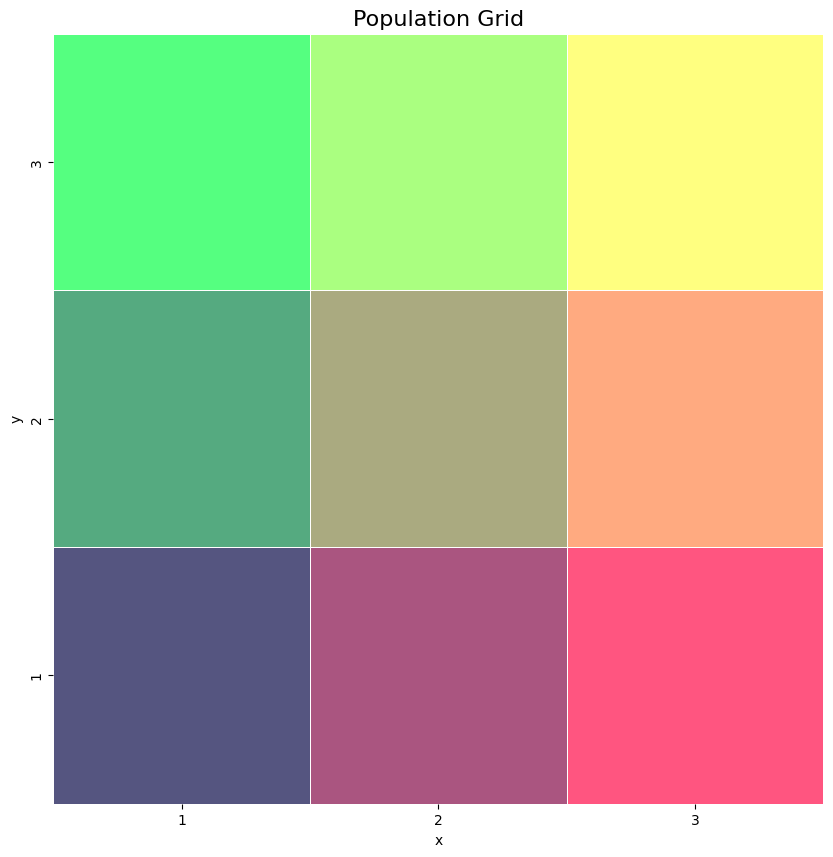

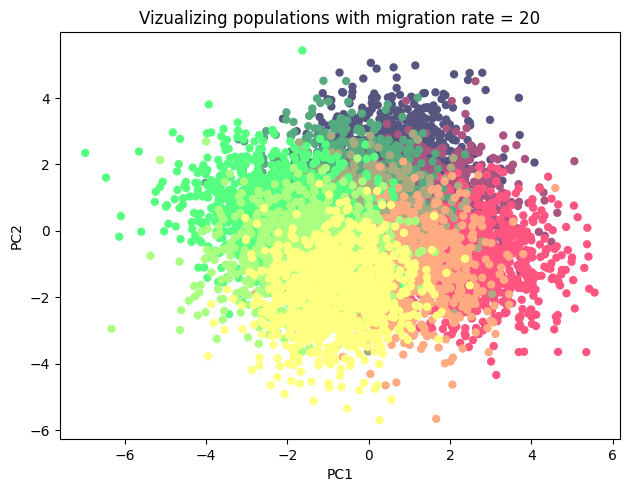

In [31]:
humans
humans['x'] = ((humans['populations'] - 1) % k) + 1
humans['y'] = ((humans['populations'] - 1) // k) + 1
humans['z'] = 0.5
palette = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
df_agg = humans.groupby(['x', 'y']).agg({'populations': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='populations')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

scaler = StandardScaler()
scaled_geno = scaler.fit_transform(geno)
n_components = max(min(geno.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_geno = pca.fit_transform(scaled_geno)
PC_geno = pd.DataFrame(data=PC_geno, columns=pc_labels_complete)

PC_geno['populations'] = humans['populations']

sns.scatterplot(x='PC1', y='PC2', data=PC_geno, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

# Create risks

<Axes: xlabel='x', ylabel='y'>

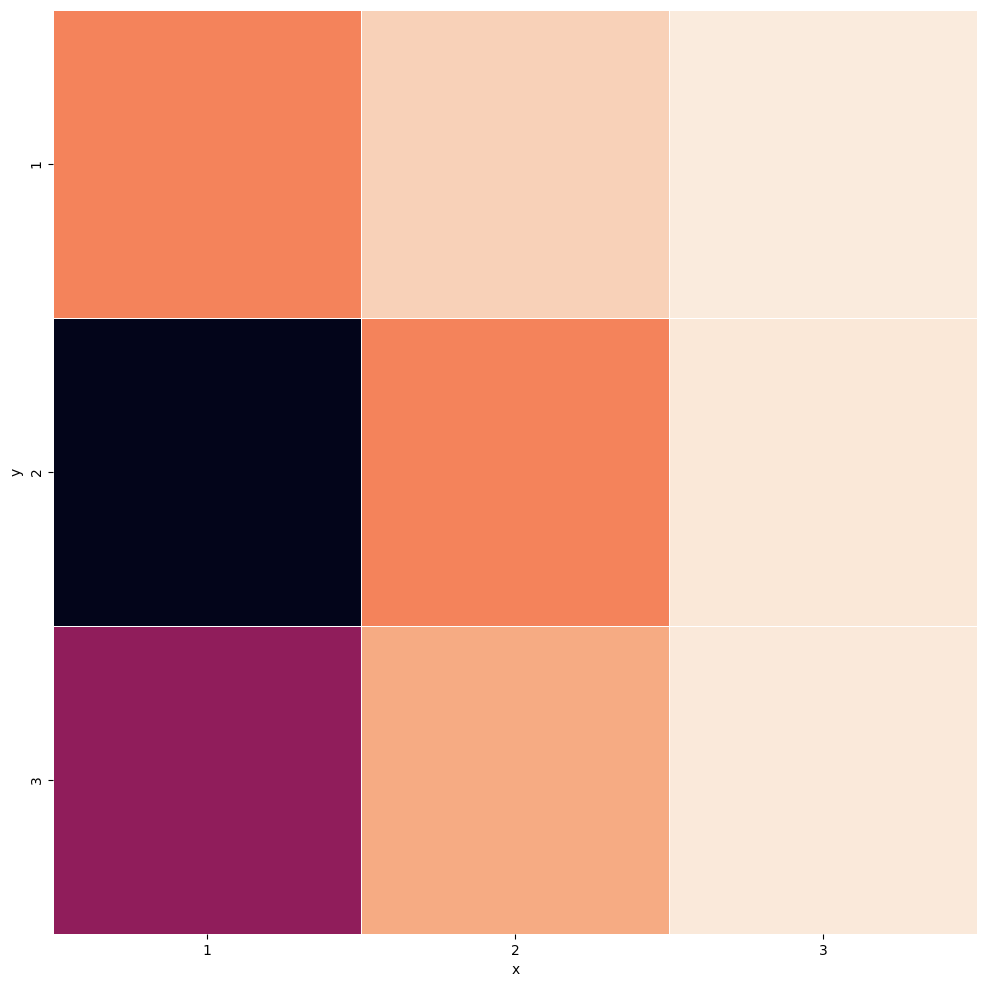

In [32]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)

risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
humans['x_temp'] = humans['x']/k
humans['y_temp'] = humans['y']/k
humans[name_risk] = list(humans.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
humans[name_risk] = humans[name_risk].astype('float')

# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# No correction only ENV

In [33]:
humans['risk'] = humans[name_risk] - humans[name_risk].mean()

y = humans['risk']
betas_snps = []
intercept_snps = []
logP_snps = []
mafs = []
max_beta = {}
for snp in geno.columns:
    beta_snps = manhattan_linear(geno[[snp]], y)
    betas_snps.append(beta_snps['coefs'][0])
    max_beta[snp] = abs(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])
    mafs.append(float(snp.split('_')[-1]))

In [34]:
to_check = max(max_beta, key=max_beta.get)
to_check

'VRG474_AF_0.008388888888888888'

In [35]:
"""
import statistics

# Assuming max_beta is a dictionary
mean_value = statistics.mean(max_beta.values())

# Find the key whose value is closest to the mean
to_check = min(max_beta, key=lambda k: abs(max_beta[k] - mean_value))

print(to_check)
"""

'\nimport statistics\n\n# Assuming max_beta is a dictionary\nmean_value = statistics.mean(max_beta.values())\n\n# Find the key whose value is closest to the mean\nto_check = min(max_beta, key=lambda k: abs(max_beta[k] - mean_value))\n\nprint(to_check)\n'

In [36]:
maf_dfs = pd.DataFrame(np.where(proto_geno == 1.0, true_p2s, np.where(proto_geno == 0.0, true_twopqs, true_q2s)), columns=proto_geno.columns)

In [37]:
nr_snps = maf_dfs[to_check]*c

In [38]:
humans['snp'] = geno[to_check]
humans['pop'] = PC_geno['populations']
humans['snp_nr'] = nr_snps
X = humans[['snp']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-0.5741012894057201


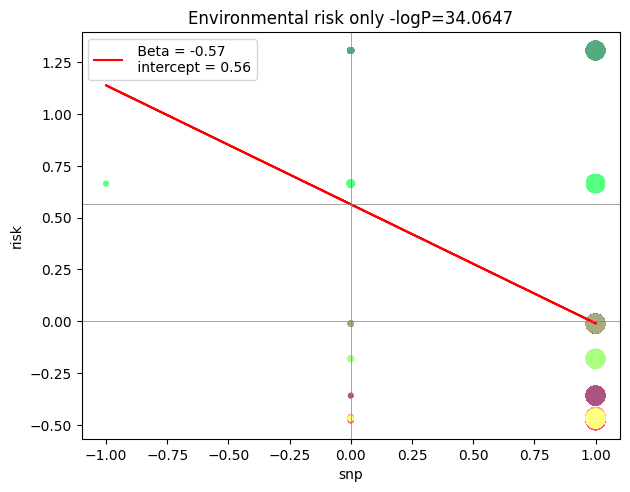

In [39]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='risk', data=humans, color=palette, linewidth=0, legend=False, size='snp_nr',sizes=(20, 200))

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

# shifting heterozygous

In [40]:
heteroshift = pd.DataFrame(np.where(proto_geno == 0.0, true_q2s - true_p2s, 0), columns=proto_geno.columns)

In [41]:
geno = geno+heteroshift

In [42]:
humans['snp'] = geno[to_check]
humans['pop'] = PC_geno['populations']
humans['snp_nr'] = nr_snps
X = humans[['snp']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-0.2968152274449968


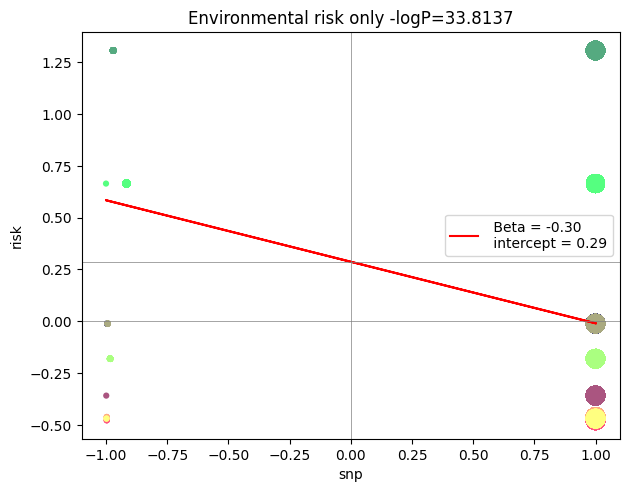

In [43]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='risk', data=humans, color=palette, linewidth=0, legend=False, size='snp_nr',sizes=(20, 200))

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

# division by AF

In [44]:
correction = proto_geno/maf_dfs

In [45]:
humans['snp'] = correction[to_check]
humans['pop'] = PC_geno['populations']
humans['snp_nr'] = nr_snps
X = humans[['snp']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-0.0006630868772714465


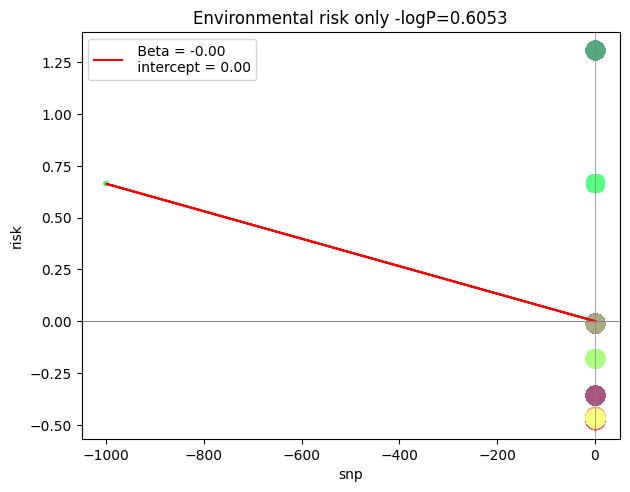

In [46]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='risk', data=humans, color=palette, linewidth=0, legend=False, size='snp_nr',sizes=(20, 200))

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()